<h1>The5Outliers - <span style="background: linear-gradient(to right, #28649c, #1dc2b1); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>: why so many players pass through World regions to reach their target</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [135]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import config
from src.utils.HTMLParser import HTMLParser
from src.data.data_loader import *
from src.utils.helpers import *
from src.utils.plot_helpers import *
from src.models.networks import *
from src.models.similarity_matrices import *
from src.models.markov_chains import *

parser = HTMLParser()
parser.load_pickle()

In [3]:
# Delete for final version?
# Compute and save all embending, similarity matrices and parsed articles
#compute_save_all()

# 0. Data preprocessing and loading

<div class="alert alert-block alert-info">

We use the `read_all()` function to load, clean, and enhance the data with useful features for analysis. It combines multiple data sources, performs preprocessing, and computes additional features for articles and user paths.

</div>

## Preprocessed Dataframes:
<div class="alert alert-block alert-info">

- `df_article_names`: Valid article names, that is without special characters and discardig any invalid articles (e.g. non-Wikispeedia articles or with missing categories).
- `df_html_stats`: Gathers wikispedia page statistics like number of links, link density, and structural information from the HTML version of each article.
- `df_categories`: Article categories and sub categories.
- `df_links`: Links inward and outward between articles.
- `df_shortest_path_length`: Matrix of shortest paths lengths possible between two articles.
- `df_unfinished` and `df_finished`: Cleaned paths with computed features.
- `df_sm` and `df_scat` (not returned): Matrices for semantic and category similarity.
- `df_article`: Dataframe with article-level features.

<div>


In [4]:
# Load and preprocess the data
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_article = read_all()

# Save old categories, needed to make the flourish sankey plot 
df_categories_og=df_categories.copy()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Great', 'Macedonia', ' Zebra', 'Bogota', 'Netbook', 'Usa', 'Christmas', 'Fats', 'The', 'Kashmir', 'Adolph Hitler', 'Rat', 'Black ops 2', 'English', 'Georgia', 'Pikachu', 'Test', 'Podcast', 'Mustard', 'The Rock', 'Western Australia', 'Charlottes web', 'Rss', 'Sportacus', 'Long peper'}
Invalid articles found in path: {'Pikachu', 'Local community', 'Private Peaceful', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Osteomalacia', 'Pikachu', 'Local community', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51196


## Key Modifications

### 1. Categories:
<div class="alert alert-block alert-info">
Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels. We observe that some articles are associated with multiple categories, highlighting overlaps and shared connections within the dataset. For our analysis we need to have only one category corresponding to each article, thus we choose to keep the most specific one.

Attributing the **first level category** based on the one **with fewer total articles** helps prioritize specialization over generality. 

Categories with fewer total articles are typically more specific, while those with higher counts cover broader topics. By focusing on the category with fewer articles, we ensure the article’s primary focus is on a unique or specialized perspective, providing a clearer thematic assignment. This method promotes a balanced classification system, ensuring articles are categorized accurately without being overshadowed by more general categories.

- For example, a category like **"Science"** may encompass a wide range of topics, while **"IT"** might be more specialized.
</div>

In [5]:
df_categories_original = read_categories()
# Count the number of articles with multiples categorie
df_categories_original.groupby("article")["article"].size().value_counts()

article
1    3986
2     590
3       8
Name: count, dtype: int64

In [6]:
labels, parents, values, ids = create_treemap_data(df_categories_original, show_articles=True)

create_colored_treemap(labels, parents, values, ids,color_palette=config.PALETTE_CATEGORY_DICT_COLORS, 
                       title="Category Distribution in Articles", background_color="white")
print(f'We have {df_categories_original["level_1"].unique().size} distinct level 1 categories.')

We have 15 distinct level 1 categories.


### 2. Article Features:

<div class="alert alert-block alert-info">

- **In-Degree**: of an article corresponds to the number of links on other pages targetting an article 
    - Some articles have no articles leading to it.
- **Out-Degree**: of an article corresponds to the number of links towards other pages on this article
    - Some articles lead to no other articles.
- **HTML Stats**: Structural details like the number of links per article.
    - Links do not consider duplicates inside the page (each link is considered to appear once) but this is relaxed with the HTML parsing.
- **Categories**: Assigns the most specific category to each article.
</div>

### 3. Path Features:
<div class="alert alert-block alert-info">
Metrics computed for user navigation paths:

- **Path Length**: Number of articles in a user's path.
- **Back-Clicks**: How many times users revisit previous articles.
- **Cosine Similarity**: Semantic similarity between source and target articles.
- **Shortest Path**: Length of the shortest path possible between the source and target articles.
- **Category Similarity**: Category similarity between the categories of the source and target articles.
</div>

# 1. Find Voyages

## 1.1 Define "World Regions"

<div class="alert alert-block alert-info">

The goal of our research is to explore the role and significance of World Regions in user behavior while playing Wikispeedia. To achieve this, we first extract articles corresponding to *World Regions*.  
Fortunately, articles are categorized, so we gather those under *'Countries'* and relevant subcategories of *'Geography'* such as *'Geography of Asia'*. These articles are grouped into a new category called *'World Regions'*, while remaining *'Geography'* articles are keeping the same category.

</div>

In [7]:
world_regions_categories = ['Geography of Great Britain', 'Geography of Asia', 'Geography of Oceania Australasia', 'North American Geography', 'European Geography', 'African Geography', 'Central and South American Geography', 'Antarctica', 'Geography of the Middle East', 'African Countries', 'Countries']
df_categories = assign_world_region_categories(df_categories, world_regions_categories)

<div class="alert alert-block alert-info">

Below we can observe the new distributions of articles categories after the most specific category and the assignement of the new categorgories world regions.
</div>

In [8]:
labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories, show_articles=True)
cat_fig = create_colored_treemap(labels_filtered, parents_filtered, values_filtered, ids_filtered,color_palette=config.PALETTE_CATEGORY_DICT_COLORS, 
                                 title="Category Distribution in Articles", background_color="white")

In [9]:
# Save the Plotly figure as a full HTML file
#cat_fig = create_colored_treemap(labels_filtered, parents_filtered, values_filtered, ids_filtered,color_palette=config.PALETTE_CATEGORY_DICT_COLORS, title="Category Distribution in Articles", background_color="#fafaf9")
#cat_fig.write_html("figures/categories.html", include_plotlyjs="cdn")

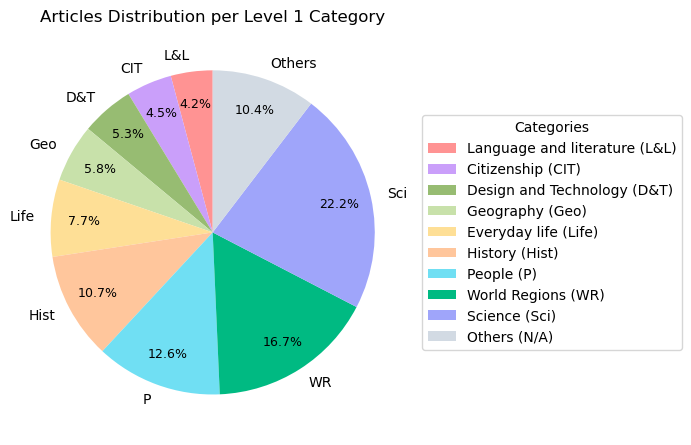

In [10]:
plot_articles_pie_chart(df_categories, config.PALETTE_CATEGORY_DICT_COLORS, config.CATEGORY_ABBREVIATIONS)

## 1.2 Sort games into voyage or not-voyage

<div class="alert alert-block alert-info">

A <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> is defined as a path game where neither the source nor the target is in **World Regions**, but the path includes at least one article from this category.
</div>

In [11]:
# Sort paths into voyage and non-voyage
df_finished = game_voyage_sorting(df_finished, df_categories)
df_unfinished = game_voyage_sorting(df_unfinished, df_categories)

# Assign the categories "World Regions" to the concerned articles
category_map = dict(zip(df_categories["article"], df_categories["level_1"]))
df_article["category"] = df_article["article"].map(category_map)

In [12]:
# Count the voyages 
voyage_count = (df_finished['Wikispeedia_Voyage'] == 1).sum() + (df_unfinished['Wikispeedia_Voyage'] == 1).sum()
non_voyage_count = (df_finished['Wikispeedia_Voyage'] == 0).sum() + (df_unfinished['Wikispeedia_Voyage'] == 0).sum()

# Concatenate all games in a dataframe and plot the sankey diagram 
df_merged = pd.concat([df_finished, df_unfinished], ignore_index=True, sort=False)

print('Out of the ', len(df_finished)+len(df_unfinished), ' finished and unfinished games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')

Out of the  75905  finished and unfinished games : 
  -  26026  are voyages
  -  49879  are not


<div class="alert alert-block alert-success">

We immediately see that <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> are very common since they are approximately one third of the paths.

In [13]:
#TODO: the sankek plot here!!!!  (the two of them)

# 2. Wikispeedia Network Structure

<div class="alert alert-block alert-info">
World Regions are overrepresented and we thus aim to understand to what extent the network structure influences gameplay and the choice to undertake <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>. In order to do that we want to model the transition probabilities between articles using Markov Chains. However we first need to verify the assumption made for Markov networks: every link in an article is equally likely to be clicked. We can have a look at how link position influences whether they are clicked or not. If we find for instance that only the first few links are generally clicked, the uniform link choice assumption may be false.
</div>

## 2.1. Articles Overview

<div class="alert alert-block alert-info">
In this section we first do an initial exploration of distribution of words, links, and categories in the articles. This will help us understand the structure and content of the articles in the Wikispeedia dataset.
</div>

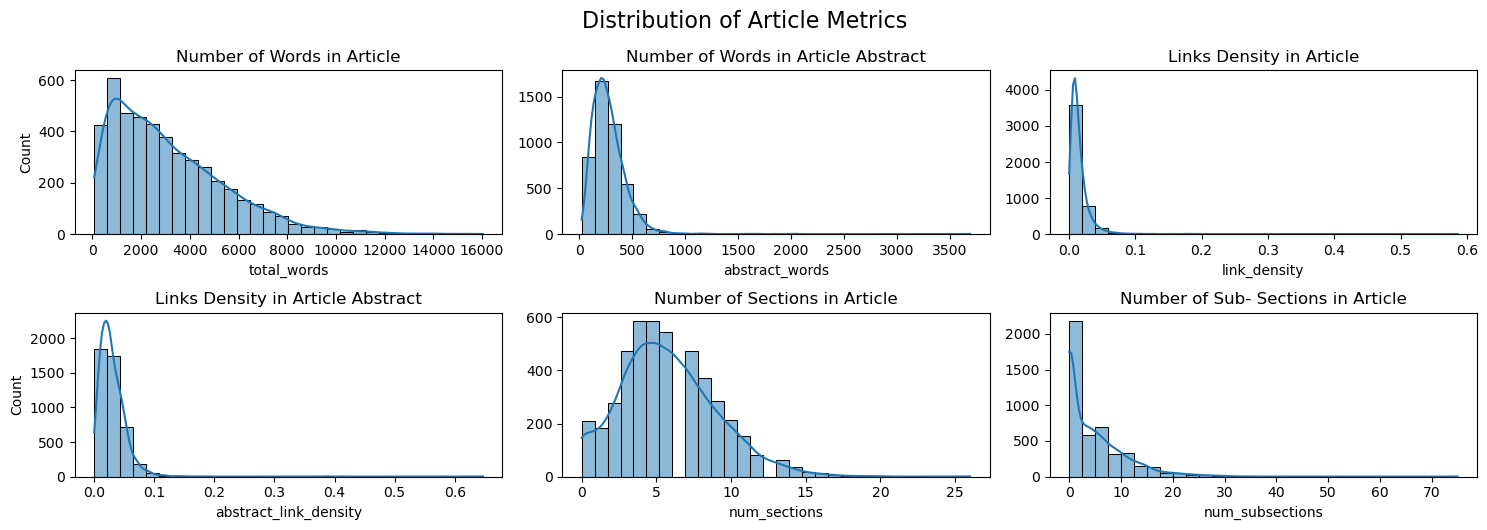

In [14]:
metrics = [
    ("total_words", "Number of Words in Article"),
    ("abstract_words", "Number of Words in Article Abstract"),
    ("link_density", "Links Density in Article"),
    ("abstract_link_density", "Links Density in Article Abstract"),
    ("num_sections", "Number of Sections in Article"),
    ("num_subsections", "Number of Sub- Sections in Article")
]

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Loop through metrics to create histograms
for i, (metric, title) in enumerate(metrics):
    row, col = divmod(i, 3)
    sn.histplot(df_article, x=metric, bins=30, kde=True, ax=ax[row, col])
    ax[row, col].set_title(title)
    if col == 1 or col == 2:
        ax[row, col].set_ylabel('')

plt.tight_layout()
plt.suptitle("Distribution of Article Metrics", y=1.05, fontsize=16)
plt.show()

<div class="alert alert-block alert-success">

The data is right-skewed for most of metrics, indicating that while most articles adhere to certain standards of complexity and length, a small subset stands out as particularly detailed or interconnected.

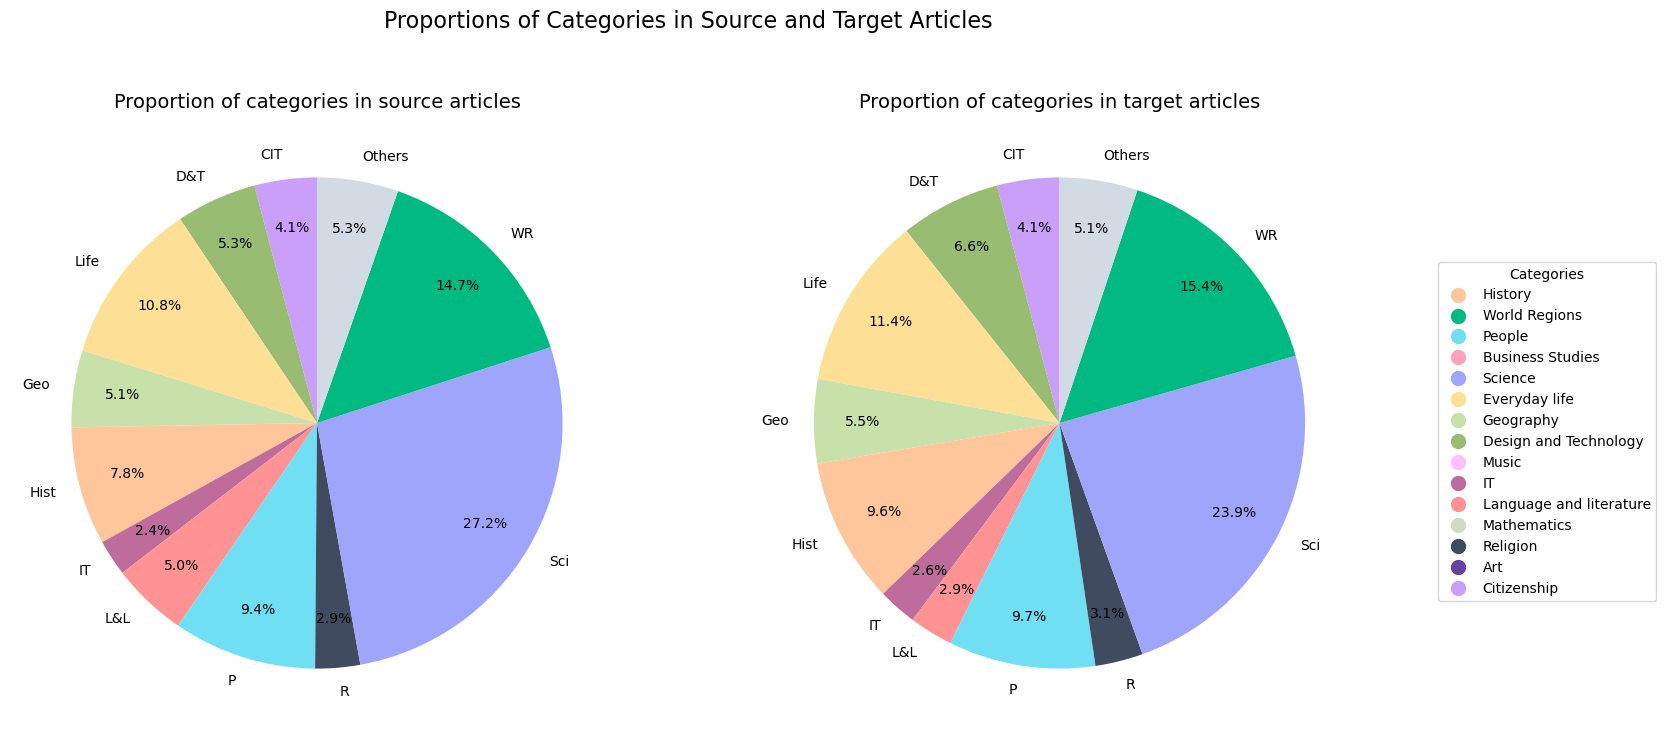

In [15]:
#add count of start and target in df_articles
count_start_and_target_per_articles(df_finished, df_unfinished, df_article)

plot_proportion_category_start_stop_pies(
    df_article=df_article,
    palette=config.PALETTE_CATEGORY_DICT_COLORS,
    abbreviations=config.CATEGORY_ABBREVIATIONS,
    threshold=2.3
)

<div class="alert alert-block alert-success">

"Science" and "World Regions" categories are the most prevalent categories in both source and end articles, indicating their significant representation.

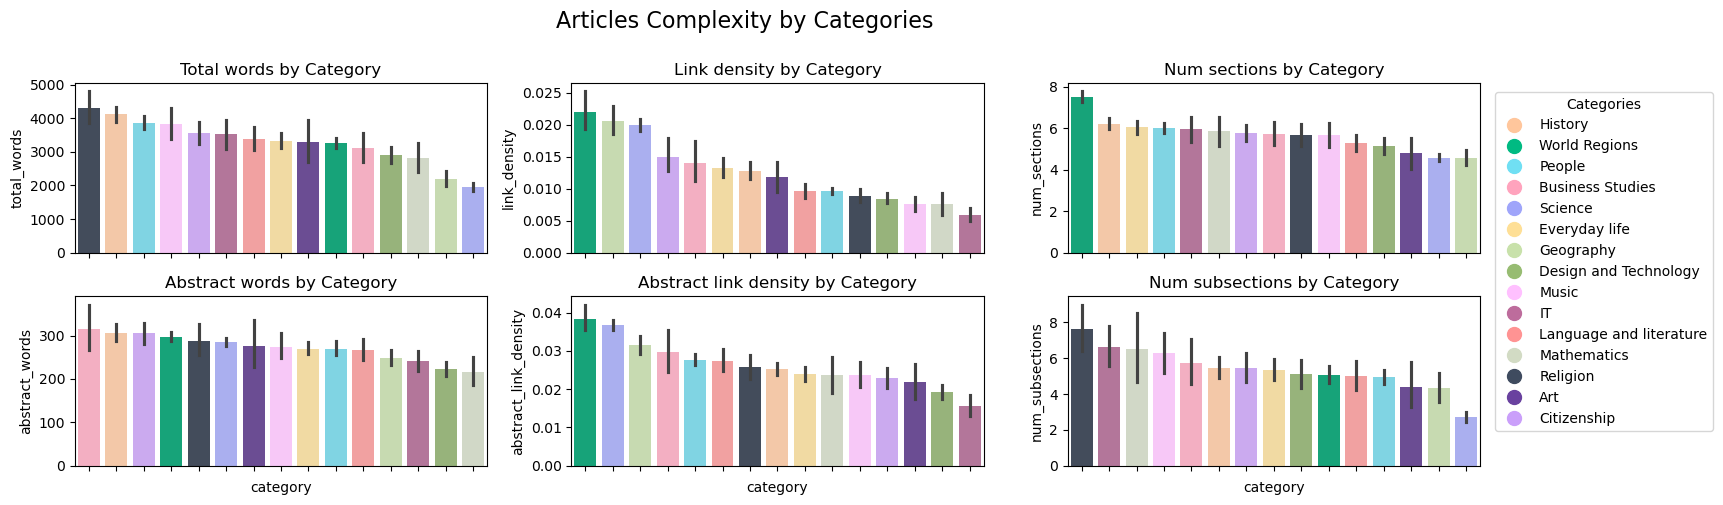

In [16]:
metrics = [
    "total_words", "link_density", "num_sections",
    "abstract_words", "abstract_link_density", "num_subsections"
]

plot_metrics_by_category(df_article, metrics, config.PALETTE_CATEGORY_DICT_COLORS, config.CATEGORY_ABBREVIATIONS)

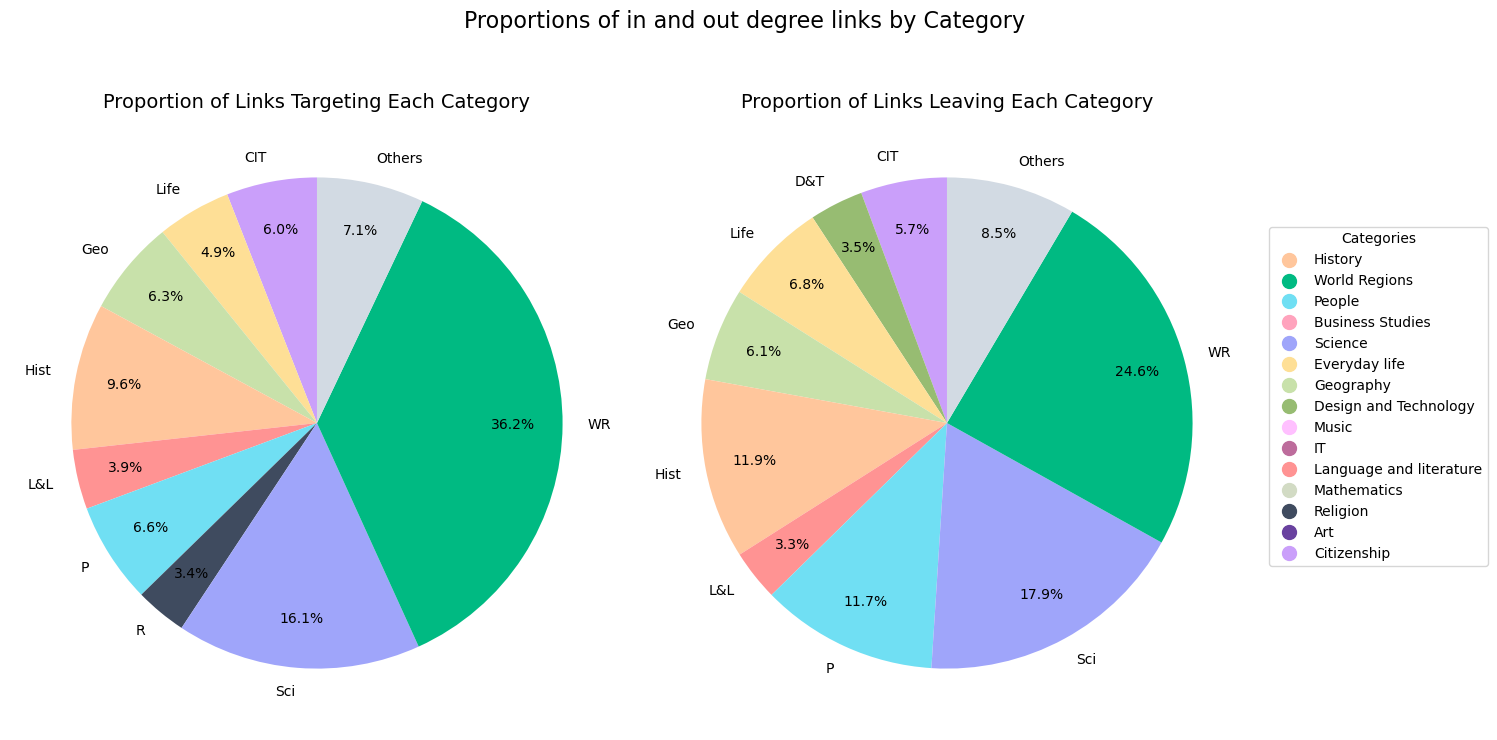

In [17]:
plot_proportions_of_in_and_out_degree_in_categories(
    df=df_article,
    palette=config.PALETTE_CATEGORY_DICT_COLORS,
    abbreviations=config.CATEGORY_ABBREVIATIONS
)

<div class="alert alert-block alert-success">
World Regions is the category with higher link density (also if considering only the abstract) and number of sections. This category seem to be highly connected to the others.

<div class="alert alert-block alert-info">

Is there a correlation between the number of links in an article and the frequency with which people interact with it in the game? Does this depend more on the in-degree or out-degree of the links? And is there a significant difference between the in-degree and out-degree of links? We will compare and investigate these factors to understand their impact on article interaction.

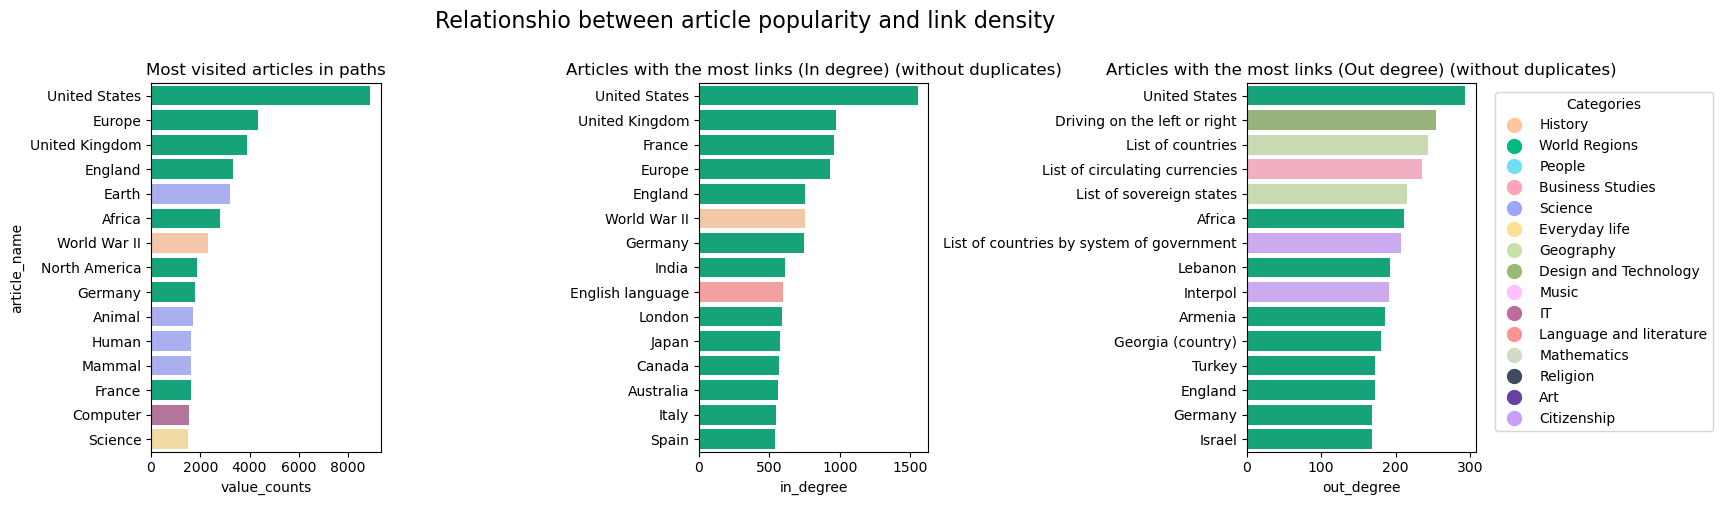

In [20]:
plot_article_popularity_link_density(df_article, df_finished, config.PALETTE_CATEGORY_DICT_COLORS, df_categories)

<div class="alert alert-block alert-success">

We observe an overlap between the most visited articles and those with the highest links degree. Additionally, World Regions are prominently represented.

## 2.2 Page structure

<div class="alert alert-block alert-info">

To relax the assumption made for Markov networks that every link in an article is equally likely to be clicked, we can have a look at how link position influences whether links are clicked or not. If we find for instance that only the first few links are generally clicked, the uniform link choice assumption may be false.

</div>

<div class="alert alert-block alert-info">

##### Where are the links to a certain category in a page ?
To achieve this, the first step is to identify the position of links to a specific category within each article. By "position", we mean the ranking of the link, such as whether it is the first link, the last link, or somewhere in between. We will normalize the positions, where 0 represents the first link and 1 represents the last link. 
Next, we will compute the distribution of these category-specific links across all articles. This will help us determine whether a particular category of links tends to appear more frequently at the beginning of pages, in the middle, at the end, or if there is no discernible pattern. Understanding this distribution will allow us to assess whether users' link choices are influenced by the position of the links on the page.

</div>

In [ ]:
link_per_cat = find_category_position_articles(parser, df_categories, config.CATEGORIES_OTHERS)
df_category_position = pd.DataFrame(link_per_cat)
df_category_position.describe()

<div class="alert alert-block alert-success">
We can see here that the median and mean position of the links for each categories is near 0.5. This means that all link of each categories are randomly distributed in the pages.
</div>

<div class="alert alert-block alert-info">

##### Where do people click on an article page ?
To compare this information with user behavior, we can analyze the positions of the links that users actually clicked on. If users tend to click on the first links more often than the last ones, this would suggest that link position influences user behavior.
To perform this analysis, we will calculate the potential position of the clicked link for each article in each path. If the target article's link appears multiple times on the page, we will use the mean position of these links as the representative value.
</div>

In [ ]:
df_merged = location_click_on_page(df_merged, parser)

In [ ]:
plot_comparison_category_click_position(df_merged, df_category_position)

<div class="alert alert-block alert-success">
Note here that the p-values represent a t-tests comparison between the distribution of "All" and the distribution of each categories.
We can observe that, whereas the links are uniformly distributed in the pages, users tend to click on the first links slightly more often than the last ones (median of 0.43). This indicates that the position of links influences user behavior, however the median is not so far from the middle of the page, which represents the case where user are not influenced by link position.
</div>

<div class="alert alert-block alert-info">

##### In which section of the page are the links ? In which section do people click ?
Similarly, we can compare the distribution of links across the Core, Abstract, and Info-box sections of the page to the distribution of clicked links. As before, we will determine the section (Core, Abstract, or Info-box) of the clicked links for each article in each path. If the target article's link appears multiple times in different sections of the page, we will consider all occurrences and calculate the mean position as the representative value. We will compare this distribution with the distribution of section of all link in all articles across all paths.
</div>

In [ ]:
plot_donut_link_position(df_merged, colors = config.PALETTE_SECTIONS)

<div class="alert alert-block alert-success">
Users click significantly more on the Abstract (30% of clicks, compared to only 8% of links). They also engage with the Info-boxes (12% of clicks, though they represent only 5% of links).
</div>

## 2.3 Markov chains

### 2.3.a Networks

<div class="alert alert-block alert-info">

Before diving into detailed comparisons between user behaviur and random network transitions, it is important to first explore the general structure of transitions between categories. This helps us establish a baseline understanding of both the **users' navigation patterns** and the **inherent structure of the Wikispeedia network**.

We create a network *(directed graph)* to represent transitions between different categories of articles:

1. **Nodes:** Each node represents a category of articles, where individual articles are grouped under their primary category.
    - The **node size** reflects the number of articles within a category
2. **Edges:**  Directed edges indicate transitions between categories, whether observed in user paths or inferred from link structure.
    - The **edge width** represents the frequency of transitions between categories.
    - Self-loops (transitions within the same category) are excluded to focus on inter-category transitions.

A **force-directed algorithm** positions the nodes dynamically, ensuring clear visualization:

- Nodes repel each other like charged particles to avoid overlaps.
- Edges act like springs, pulling connected nodes closer to reflect their relationships.

</div>

#### User Transitions

<div class="alert alert-block alert-info">

Transitions are derived from actual user navigation paths, where each transition represents a deliberate action taken by a user.

- We use the merged paths, analyzing how users transition between categories of articles regardless of their success in completing the game.

- Backclicks **(<)** are recursively replaced with the preceding article to reconstruct the original path. This ensures accurate identification of the corresponding category for each step.

</div>

In [ ]:
df_merged_no_backclick = df_merged['path'].apply(replace_back_clicks)
G_user = build_network_from_paths(df_merged_no_backclick, df_categories, include_self_loops=False)

In [ ]:
plot_network(G_user, df_categories,palette=config.PALETTE_CATEGORY_DICT_COLORS, node_abbreviations=config.CATEGORY_ABBREVIATIONS, show_edge_labels=False, 
             title="User Navigation Network: Transitions Between Article Categories")

<div class="alert alert-block alert-success">

The graph reveals a clustered structure, with 8 out of 15 categories forming a central hub where users frequently navigate. This hub is dominated by categories with the largest number of articles, such as Science, World Regions, and People.

In contrast, some categories, like Art and Math, appear more isolated, positioned at the periphery of the network.

</div>

In [ ]:
# Save the plot for the website with transparent background
#plot_network(G_user, df_categories,palette=config.PALETTE_CATEGORY_DICT_COLORS, node_abbreviations=config.CATEGORY_ABBREVIATIONS, show_edge_labels=False, title="User Navigation Network: Transitions Between Article Categories", save_path="figures/network_user.png", background_color="transparent")

#### Structural Wikispedia Transitions

<div class="alert alert-block alert-info">

Structural Transitions capture the inherent connectivity of the Wikispeedia network, reflecting how the structure of links between articles influences navigation. By modeling the network as a *Markov chain*, we can infer transition probabilities based purely on link distribution.

- The model assumes that all links are equally likely to be clicked, which serves as a baseline for comparing user behavior.

This visualization demonstrates the bias introduced by the network's structure, highlighting which categories are more interconnected or serve as hubs due to the distribution of links. It provides a baseline for understanding the impact of the network's topology on navigation patterns.

</div>

In [ ]:
markov_transitions_cat = get_transition_probabilities(df_article_names, parser, backclicks=False, normalise=False)
markov_transitions_cat = pd.DataFrame(markov_transitions_cat)
markov_transitions_cat.index = df_article_names
markov_transitions_cat.columns = df_article_names
G_structure = build_network_from_matrix(markov_transitions_cat,category_map,include_self_loops=False)

In [ ]:
plot_network(G_structure, df_categories, palette=config.PALETTE_CATEGORY_DICT_COLORS, node_abbreviations=config.CATEGORY_ABBREVIATIONS, show_edge_labels=False,
             title="Structural Network: Link-Based Transitions Between Article Categories")

<div class="alert alert-block alert-success">

In the structural Wikispeedia network, we observe a similar distribution; however, this time, the focus is more centered around three categories: People, History, and World Regions, with World Regions clearly highlighting its centrality.

Interestingly, despite being the largest category, Science appears less central in this network, emphasizing a shift in prominence compared to the user navigation perspective.

</div>

In [ ]:
# Save the plot for the website with transparent background
#plot_network(G_structure, df_categories, palette=config.PALETTE_CATEGORY_DICT_COLORS, node_abbreviations=config.CATEGORY_ABBREVIATIONS, show_edge_labels=False, title="Structural Network: Link-Based Transitions Between Article Categories", save_path="figures/network_structure.png", background_color="transparent")

<div class="alert alert-block alert-info">

By visualizing both user transitions and structural transitions, we gain valuable insights into how navigation patterns are shaped by user behavior versus the network’s structure. However, aggregating articles into categories introduces potential biases:

- Larger categories may dominate the visualization, overshadowing smaller but significant transitions.
- Prominent articles within a category may not be adequately represented, complicating the analysis.

Although category-based graphs simplify the visualization of shifts in navigation patterns, they can obscure finer details. To address this, we now analyze the network at the article level, exploring how user navigation deviates within and across categories.

These visualizations lay the foundation for the next step: comparing user behavior with random transitions using Markov models and Kullback–Leibler ($KL$) divergence.

</div>

### 2.3.b User behaviour vs. random network transitions

<div class="alert alert-block alert-info">

There seems to be some inherent bias of the categories just by the structure of the Wikispeedia network. Indeed, it seems much more likely to end up in World Regions or Science just because the categories are much bigger and more links lead to it. Maybe there is a way of disentangling the user behaviour from the network structure? If we consider that users only click on links randomly (i.e. a random walk in the Wikispeedia Network), we can capture the effect of the network structure. Indeed, if taking a random walk always leads you to World Regions, then maybe the users do not actually choose to go there but the network structure just makes it very likely that they end there anyway.

To model this, Markov chains come in handy: we can model the transition probabilities from one article A to an article B just by counting the number of links to article B in article A, and dividing by the number of links there are on the page in total. While this does not eliminate all bias (for instance, links further up in the page may be clicked more), this Markov chain still gives valuable insight about the network structure.

To get an equivalent transition matrix for users, we can simply count the transitions users actually made at each step. To compare the two obtained probability distributions, we will use the Kullback–Leibler ($KL$) divergence, a type of statistical distance measuring how much a model probability distribution $Q$ (the random probabilities) differ from a probability distribution $P$ (our users' transitions). The KL-divergence is defined as

$$ D_{KL}(P || Q)_{ij} = P_{ij} \log \frac{P_{ij}}{Q_{ij}} $$


It is 0 when $P$ and $Q$ are exactly the same or when the user transition probability is 0. A higher value indicates a stronger divergence: if the divergence is high, users choose a certain transition more than the random transitions in the network would suggest. That is, the users actually choose this transition and it is not only due to the network structure.
</div>

In [ ]:
df_paths = pd.concat([df_finished[['path', 'path_length']], df_unfinished[['path', 'path_length']]])

markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')

<div class="alert alert-block alert-info">

First, let's see whether the obtained transition matrix makes sense with what we have observed previously. Let's have a look at which articles we seem to converge naturally to when taking a random walk in the Wikispeedia network.

The transition matrix's $P$ left eigenvector with eigenvalue $1$ (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is $1$. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

In [ ]:
# Markov steady-state with back-clicks
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=True)
ssb = compute_steady_state(markov_transitions, df_article_names, backclicks=True)
ssb.sort_values(by='steady_state_proportion', ascending=False).head(5)

In [ ]:
# Markov steady-state with back-clicks
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
ss = compute_steady_state(markov_transitions, df_article_names)
ss.sort_values(by='steady_state_proportion', ascending=False).head(20)

In [ ]:
merged_df = pd.merge(df_categories[['article', 'level_1']], ss, left_on='article', right_on='articles', how='inner')
filtered_df = merged_df[merged_df['level_1'] == 'World Regions']
plt.hist(filtered_df.sort_values(by='steady_state_proportion')['steady_state_proportion'], bins=50, color='#00ba82')
plt.title('Histogram of World Region Articles Steady State Probability (log-log scale)')
plt.xlabel('Steady State Probability (log)')
plt.ylabel('Count (log)')
plt.yscale('log')
plt.xscale('log')

<div class="alert alert-block alert-info">

We considered 2 scenarios: one with a "back-click article", which appears once on every page and therefore has a non-null probability of being chosen. The transition from this "back-click article" leads uniformly to all articles, as we make the assumption that every article is equally likely to be reached from a back-click. While this is certainly not true, it is an easy hypothesis to make in a system that is agnostic of player behaviours. The other scenario removes the possibility of using backclicks.

To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. In the first scenario, we see that with our assumptions, back-clicks are very favoured by the network (more than $2\%$ probability to back-click). This makes sense, as it is present on every article in Wikispeedia. 

In the second scenario, United States is the most likely article to be in ($1.35\%$ probability), followed mainly by other countries. It looks like countries are naturally favoured by the network structure. This is interesting as it shows that there is definitely a bias towards World Regions (particularly large countries) in Wikispeedia articles: they have more links and are more interconnected than other articles. This is a first hint that World Regions are intertwined with the human mind, as humans wrote the articles in questions and made them particularly rich and link-dense.

<b>Note:</b> Most of the World Region articles in fact have a steady state probability that is almost 0. That means that only a subset of the World Region articles actually contribute to the effect of Wikispeedia Voyages that we observed. This is an important conclusion : while all our previous conclusions remain valid, it is important to note that the conclusions would probably be more extreme when focussing only on a subset of hubs within World Regions.


</div>

<div class="alert alert-block alert-success">

To answer our initial question (whether users choose World Region articles more than random) we need to compare the random transitions with the user transitions through the $KL$ divergence introduced above.
</div>

In [ ]:
%%capture
KL = np.where((user_transitions > 0) & (markov_transitions > 0), user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_df = pd.DataFrame(KL, columns=user_transitions.columns, index=user_transitions.index)

In [ ]:
mean_KL = pd.DataFrame()
mean_KL['mean'] = KL_df.mean(axis=0)
mean_KL['CI'] = 1.96 * KL_df.sem(axis=0)
mean_KL.sort_values(by='mean', ascending=False).head(10)

In [ ]:
sn.heatmap(KL_df.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.ylabel('Pre-Transition Article')
plt.ylabel('Post-Transition Article')
plt.title(r'$KL$ Divergence for a Subset of Articles')
plt.show()

<div class="alert alert-block alert-info">

It seems that even when comparing the random transitions (that already favour World Region articles) with the user transitions, there is a consistent bias towards World Region articles. This shows that users use certain articles more than the already favourable random transitions would suggest. This could have multiple reasons: it could be because users are more comfortable with the articles' topic, but it could also be as part of the users' strategy, if users noticed that these articles had promising connectivity.

</div>

In [ ]:
%%capture
mean_KL_step = get_step_divergences(df_article_names, parser, df_paths, backclicks=False)

In [ ]:
N_articles = 10
main_mean_div = mean_KL_step.iloc[:N_articles]
fig_art = plot_article_step_divergence(main_mean_div, df_categories, N_articles)
fig_art.show()

In [ ]:
# Save the Plotly figure as a full HTML file
#fig_art.write_html("figures/MarkovArticles.html", include_plotlyjs="cdn")

In [ ]:
%%capture
KL_cat_df = get_step_divergences(df_article_names, parser, df_paths, df_categories=df_categories, backclicks=False)

In [ ]:
backclick_palette = config.PALETTE_CATEGORY_DICT_COLORS
backclick_palette['<'] = '#000000'
fig_cat = plot_category_step_divergence(KL_cat_df, backclick_palette)
fig_cat.show()

<div class="alert alert-block alert-success">

We can take two main conclusions from these figures:
1. In the first few steps, World Region articles seem to be chosen by users much more than random. The Divergence Value is statistically significantly higher for World Regions than it is for all the other categories.
2. Certain articles in the World Region category have a much higher impact than others. Looking at the scales of mean divergence ($10^{-1}$ for United States vs $10^{-4}$ for aggregated World Regions), it seems that a few articles contribute much more than others to World Regions being so popular.

</div>

In [ ]:
# Save the Plotly figure as a full HTML file
#fig_cat.write_html("figures/MarkovCategories.html", include_plotlyjs="cdn")

#### Categories normalised by transition probabilities

In [ ]:
plot_transitions_normalized(df_article_names, parser, df_categories, palette=config.PALETTE_CATEGORY_DICT_COLORS)

<div class="alert alert-block alert-success">

This figure shows that the category World Regions have the highest number of transitions even after normalizing by the number of articles in the category. That means that the category is really highly connected and that it is not due only to the fact that it contains many articles.

</div>

# 3. Analyse user behaviour (paths)

<div class="alert alert-block alert-info">

Having explored the article structure and examined the network, we now turn our attention to analyzing user behavior to uncover potential patterns. By studying how users interact with the network, we aim to identify meaningful insights that can help us evaluate the difficulty of a game. This involves not only observing navigation choices and strategies but also exploring metrics that can serve as indicators of perceived ease or challenge.

Many different metrics can be considered, for instance:
- Game duration
- Game path length
- Difficulty rating given for finished paths
- Number of back-clicks needed
- Whether a game was finished or not
- For unfinished games, how the game was abandoned

A combination of these parameters can help finding in which games users struggled. This will then allow to assess whether players struggle less in <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than in other paths.

## 3.1 General overview

<div class="alert alert-block alert-info">
Starting with a bit of EDA to understand these metrics. We will look at the distribution of path duration, path length, user rating and back-clicks. We will also look at the correlation between these variables.
<div>

### 3.1.a Path duration and path length vs. user rating

<div class="alert alert-block alert-info">

Let's start by looking at path duration distribution over different user rating. We found similar results for finished and unfinished paths, so let's have a look at **finished ones** for example.

Note : Ratings are given by users after finishing a path, and range from 1 to 5, where 1 indicates ease and 5 indicates difficulty
<div>

In [ ]:
# change metric to 'path_length' for path length 
metric = 'durationInSec'

df_finished_strNaN = df_finished.copy()
df_finished_strNaN['rating'] = df_finished_strNaN['rating'].fillna('NaN')

plot_duration_by_rating(df_finished, df_finished_strNaN, metric)

<div class="alert alert-block alert-success">

The distributions of the path duration by rating are nice log-normal distributions! This means we can use the mean (location) and standard deviation (scale) to characterise them. Indeed, except for ``NaN``, there is a steady increase of the path duration mean when rating goes up.

<div class="alert alert-block alert-info">

Let's now look at whether path duration is correlated with path length:

In [ ]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

In [ ]:
order = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']

plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.barplot(df_finished_strNaN, x='rating', y='durationInSec', order=order, errorbar=('ci', 95), color='#0b3880')
plt.xlabel('Rating')
plt.ylabel('Duration in seconds')
plt.subplot(122)
sn.barplot(df_finished_strNaN, x='rating', y='path_length', order=order, errorbar=('ci', 95), color='#0b3880')
plt.suptitle('Duration and Path Length by Rating of the Finished Paths')
plt.xlabel('Rating')
plt.ylabel('Path Length')
plt.show()

<div class="alert alert-block alert-success">

There is a clear correlation between how long players took or how many clicks they made with the experienced difficulty rating. This means we can easily combine the two into a difficulty measure as they agree with each other on what players considered difficult. 

### 3.1.b Back-clicks
<div class="alert alert-block alert-info">

Let's now look at back-clicks: could it indicate whether players had a hard time?

The number of back-clicks made in a game may indicate players getting stuck.
Lets investigate how this metric is related with player ratings, and if they are more prominent in certain categories:

</div>

In [ ]:
# Define color palette with NaN explicitly included
blues_palette = sn.color_palette("Blues", n_colors=6)
rating_order_plot1 = ['1.0', '2.0', '3.0', '4.0', '5.0', 'NaN']  # For Plot 1
rating_order_plot2 = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']  # For Plot 2 (stacked bars)
# Map ratings to consistent colors
rating_colors = {rating: blues_palette[i] for i, rating in enumerate(rating_order_plot2)}

plot_back_clicks(df_finished,rating_order_plot2, rating_colors, rating_order_plot1)

<div class="alert alert-block alert-success">

The first plot shows us that back-clicks are correlated with the difficulty rating, which is expected as the more difficult a game is, the more likely players are to get stuck and go back.
With the second plot we can observe that the categories with the most back-clicks are "Business Studies" and "Art", and the one with the least is "World Regions" and "Design and Technology". This is interesting as "World Regions" is also one of the most visited category, which might indicate that players are more familiar with it and therefore less likely to get stuck.
Additionaly, The distribution of rating inside each category seams quite similar.

</div>

## 3.2 Difficulty measure between voyage and non-voyage games

<div class="alert alert-block alert-info">

Now that we have explored all of the metrics lets examine how they differs between Wikispeedia Voyage and non-Voyage paths, as well as between World Regions and non-World Regions categories. As we analyze the impact of user strategies, including their tendency to favor World Region articles, it’s important to explore whether this preference for World Regions correlates with ease of gameplay.

</div>

In [ ]:
plot_difficulties_voyage(df_finished, df_unfinished, config.PALETTE_CATEGORY_DICT_COLORS)

In [ ]:
df_finished.groupby(["Wikispeedia_Voyage"])["back_clicks"].mean().reset_index()

<div class="alert alert-block alert-success">

Wikispeedia Voyage paths are significantly longer in time than non-voyage paths, with more back-clicks (mean backclicks number of 0.54 compared to 0.31).There is a slightly lower number of ratings of 1 (on a scale from 1 to 5, where 1 indicates ease and 5 indicates difficulty), suggesting that the task is perceived as a bit more difficult. Contrary to what might be expected, the size of the paths (number of steps) remains the same between Voyage and Non-Voyage paths. Moreover, the completion rate for Voyage paths is higher, indicating a level of comfort or strategic advantage.

</div>

## 3.3 Evolution of similarity on paths

<div class="alert alert-block alert-info">

We’ve checked the complexity metrics for Voyage and non-Voyage paths ... so far, so good. But now it’s time to dig deeper: do players really think differently in Voyage and non-Voyage paths? Are their strategies different? One way to analyse these tactics is by tracking how the similarity between articles changes along the way.

We can get an idea of how similar one article is to another by comparing the cosine similarity of the article name embeddings. While this is not a precise method (for individual paths, the similarity may or may not make intuitive sense), it seems that the aggregated similarity over all paths does give significant results. In the following we analyse the mean similarity between one article and the next in user paths for both Voyages and Other paths. For this, we use both BERT and BGEM3 embeddings, to validate our results with at least two different models. 

</div>

In [ ]:
bert_similarity = read_similartiy_matrix(model='bert')
BGEM3_similarity = read_similartiy_matrix(model='BGEM3')

df_paths = pd.concat([df_finished[['path', 'Wikispeedia_Voyage']], df_unfinished[['path', 'Wikispeedia_Voyage']]])

bert_similarities = [
    get_path_similarities(df_paths[df_paths['Wikispeedia_Voyage']==True], df_sm=bert_similarity),
    get_path_similarities(df_paths[df_paths['Wikispeedia_Voyage']==False], df_sm=bert_similarity)
]

BGEM3_similarities = [
    get_path_similarities(df_paths[df_paths['Wikispeedia_Voyage']==True], df_sm=BGEM3_similarity),
    get_path_similarities(df_paths[df_paths['Wikispeedia_Voyage']==False], df_sm=BGEM3_similarity)
]

<div class="alert alert-block alert-info">

The similarities are computed for all paths and all steps along each path. We focus here on the first 10 steps of all paths and take the mean over each step in all paths. Because the paths have different lenghts, the mean of e.g. position L is taken over all paths that have at least L steps. Furthermore, we compute the interval as $1.96$ times the standard error, which we compute in the same fashion as the mean for each path position. We also normalise the scale to $[0, 1]$, as the similarity scores for the two models are in a different, somewhat arbitrary, range. To preserve linearity, we simply use min-max scaling for each type of embedding, setting the maximum mean similarity to 1 and the minimum to 0. 
</div>

In [ ]:
bert_normalised_means, bert_normalised_sems = get_normalised_mean_similarity(bert_similarities, 10)
BGEM3_normalised_means, BGEM3_normalised_sems = get_normalised_mean_similarity(BGEM3_similarities, 10)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
colours = ['#3470a8', '#6b6b6b', '#1dc2b1', '#919191']
labels = ['Voyage Similarities (BERT)', 'Other Similarities (BERT)', 'Voyage Similarities (BGEM3)', 'Other Similarities (BGEM3)']
means = bert_normalised_means + BGEM3_normalised_means
sems = bert_normalised_sems + BGEM3_normalised_sems

plot_similarity(axs, fig, means, sems, colours)

<div class="alert alert-block alert-success">

There is a clear trend for both types of embeddings: in the first few clicks, the articles chosen have a low similarity to the previous one. This can be interpreted as leaving the original category, because article names in different categories are likely to be less similar. After this, the similarity for the next clicks stabilises, with relatively small fluctuations.

There is also a statistically significant difference between Voyages and Other paths. Generally, both embeddings agree that the similarity along paths is generally lower for Voyages. This could indeed show that there is a stronger detour or zoom-out behaviour from users in Voyages, as the articles visited are on average less similar to one-another. This could indicates a possible use of World Regions as transitional nodes, before narrowing down to their targets. 

</div>

# 4. Comparison with optimal paths

<div class="alert alert-block alert-info">

Having established that users frequently pass through World Regions, more often than during random exploration, and that these paths are more successful despite being longer and perceived as slightly more difficult, we can now ask: is this really the best strategy? We can evaluate whether this is an effective strategy or if there might be a better approach. One way to address this question is to compare user paths with optimal paths.

Let's define the optimal path as the shortest path that can be taken. This assumption is coherent since the goal of the game is to reach the target while keeping the number of clicks as low as possible.

We can analyze whether users’ choice of categories aligns with the categories in the optimal path to determine if passing through 'World Regions' is an effective strategy for reaching the target.

To achieve this, we first need to compute the optimal path by constructing a directed graph where edges represent connections between articles. Here we take all the shortest possible paths per each combinaton of source-target present in the users' games. 

</div>

In [ ]:
# Read precomputed optimal paths
optimal_paths = pd.read_pickle('data/paths-and-graph/optimal_paths.pkl')

<div class="alert alert-block alert-success">

Some combination of source and target have many possible shortest paths!
Interestingly, some pairs have a surprisingly large number of possible optimal paths, up to 599!

</div>

In [ ]:
# Count the number of shortest paths for each (source, target) combination
path_counts = optimal_paths.groupby(['source', 'target']).size().reset_index(name='path_count')
path_counts.sort_values(by='path_count')

In [ ]:
# Map the paths artciles to their categories
optimal_paths['Category Path'] = optimal_paths['path'].apply(lambda path: map_path_to_categories(path, category_map))

# Get users paths mapped to categories and remove backclicks
users_finished, users_unfinished = users_paths(df_finished, df_unfinished, category_map)

# Filter optimal paths to match source-target pairs in users paths and remove path where target available in source
optimal_fin, users_finished, optimal_unf, users_unfinished = filter_pairs(optimal_paths, users_finished, users_unfinished)

<div class="alert alert-block alert-info">

To compare user paths with optimal paths, we calculate the percentage of times each category is visited at each step for both datasets and each source-target association.

1. We can average the percentages by groupping them by source-target category pairs (e.g., source in 'Art' and target in 'Music'), then average within these groups to balance category representation. We can then visualize the categories taken at each of the first 10 steps.

2. To examine the difference between user and optimal paths in general trends, we average these percentages across steps for each category. Next, we compute the difference between the optimal and user paths for each source-target association and category. We then average these differences by groupping them by source-target category pairs.

</div>

In [ ]:
S_T_opt_fin_percentages, S_T_fin_percentages, S_T_opt_unf_percentages, S_T_unf_percentages = calculate_step_percentages(optimal_fin, users_finished, optimal_unf, users_unfinished)

dataframes = [
    (S_T_opt_fin_percentages, 'opt'),
    (S_T_fin_percentages, 'fin'),
    (S_T_opt_unf_percentages, 'opt'),
    (S_T_unf_percentages, 'unf')
]

category_fin_means, category_unf_means=process_and_calculate_differences(dataframes, category_map, column_names=['source', 'target', 'categories'])

In [ ]:
%%capture
S_T_fin_percentages_norm_steps, S_T_opt_fin_percentages_norm_steps = process_percentages(S_T_opt_fin_percentages, S_T_fin_percentages, category_map, max_step=10)

<div class="alert alert-block alert-info">

This analysis applies to both finished and unfinished user paths. However, for easier visualization, we plot only finished paths at each step. The observed differences confirm that trends remain similar across both path types.

</div>

In [ ]:
optimal=plot_position_line(S_T_fin_percentages_norm_steps, S_T_opt_fin_percentages_norm_steps, category_fin_means, category_unf_means, config.PALETTE_CATEGORY_DICT_COLORS)

<div class="alert alert-block alert-success">

In early path positions, the category 'World Regions' appears most frequently and consistently decreases over subsequent steps, aligning with other categories. This trend holds true for both optimal and user paths.

Note that, optimal paths are often very short. After the 5th step, only a few paths remain, which predominantly include categories like 'Citizenship', causing their percentages to increase sharply at the end.

The plot clearly shows that users pass through 'World Regions' less often than optimal paths suggest. This finding was surprising, as we intuitively expected humans to use more  <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than necessary. However, the opposite is true. Users might benefit from using this category more, likely because, as shown earlier, it is highly interconnected with other categories.

</div>

# 4. Conclusion

<div class="alert alert-block alert-danger">

Let's summarize our findings:

1- World Regions articles are overrepresented and highly connected compared to other categories, but this bias alone doesn't explain user behavior: they navigate these articles more often than random algorithms predict. The page structure doesn't favor Voyages, and a few key articles significantly drive World Regions' popularity.

2- Users achieve a higher success rate in reaching their targets when employing Wikispeedia Voyages, even if these paths are often less straightforward (slower and more back-clicks). There is clear evidence of a semantic detour in Wikispeedia Voyages, as articles in these paths exhibit lower similarity scores compared to others. This indicates that users often zoom out to explore broader topics, possibly using World Regions as transitional nodes, before narrowing down to their targets. This detour reflects a distinct strategy in Voyages, aligning with the broader, exploratory nature of these paths compared to more direct approaches.

3- Optimal paths leverage World Regions more often than users, suggesting that Voyages are effective strategies that players might underuse.
</div>